In [16]:
pip install yahoofinancials

In [17]:
import numpy as np
import seaborn as sns
import pandas as pd
import time
import matplotlib.pyplot as plt
import yfinance as yf
np.random.seed(4)
from yahoofinancials import YahooFinancials
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [18]:
url='https://raw.githubusercontent.com/codificandobits/Prediccion_de_acciones_en_la_bolsa_con_redes_LSTM/master/AAPL_2006-01-01_to_2018-01-01.csv'
df = pd.read_csv(url, index_col='Date', parse_dates=['Date'])
df.head()

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2006-01-03,10.34,10.68,10.32,10.68,201853036,AAPL
2006-01-04,10.73,10.85,10.64,10.71,155225609,AAPL
2006-01-05,10.69,10.70,10.54,10.63,112396081,AAPL
2006-01-06,10.75,10.96,10.65,10.90,176139334,AAPL
2006-01-09,10.96,11.03,10.82,10.86,168861224,AAPL


In [19]:
def graficar_predicciones(real, prediccion):
    plt.plot(real[0:len(prediccion)],color='red', label='Valor real de la acción')
    plt.plot(prediccion, color='blue', label='Predicción de la acción')
    plt.ylim(1.1 * np.min(prediccion)/2, 1.1 * np.max(prediccion))
    plt.xlabel('Tiempo')
    plt.ylabel('Valor de la acción')
    plt.legend()
    plt.show()

In [23]:
set_entrenamiento = df[:'2016'].iloc[:,1:2]
set_validacion = df['2017':].iloc[:,1:2]

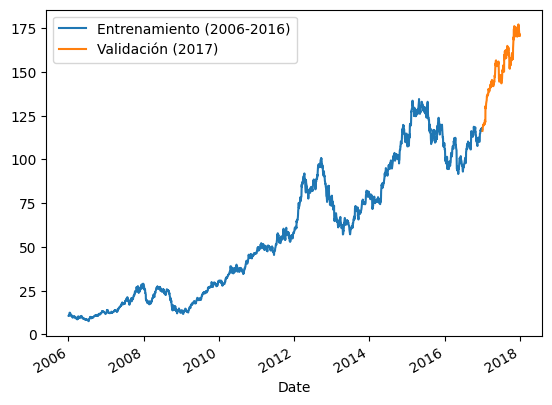

In [24]:
set_entrenamiento['High'].plot(legend=True)
set_validacion['High'].plot(legend=True)
plt.legend(['Entrenamiento (2006-2016)', 'Validación (2017)'])
plt.show()


In [26]:
# Normalización del set de entrenamiento
sc = MinMaxScaler(feature_range=(0,1))
set_entrenamiento_escalado = sc.fit_transform(set_entrenamiento)

In [29]:
time_step = 60
X_train = []
Y_train = []
m = len(set_entrenamiento_escalado)
for i in range(time_step,m):
    # X: bloques de "time_step" datos: 0-time_step, 1-time_step+1, 2-time_step+2, etc
    X_train.append(set_entrenamiento_escalado[i-time_step:i,0])

    # Y: el siguiente dato
    Y_train.append(set_entrenamiento_escalado[i,0])
X_train, Y_train = np.array(X_train), np.array(Y_train)

# Reshape X_train para que se ajuste al modelo en Keras
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [33]:
dim_entrada = (X_train.shape[1],1)
dim_salida = 1
na = 100 # 50 neuronas

modelo = Sequential()
modelo.add(LSTM(units=na, input_shape=dim_entrada))
modelo.add(Dense(units=dim_salida))
modelo.compile(optimizer='rmsprop', loss='mse')
modelo.fit(X_train,Y_train,epochs=50,batch_size=64)


Epoch 1/50
43/43 [==============================] - 5s 73ms/step - loss: 0.0121
Epoch 2/50
43/43 [==============================] - 3s 72ms/step - loss: 0.0020
Epoch 3/50
43/43 [==============================] - 3s 81ms/step - loss: 0.0015
Epoch 4/50
43/43 [==============================] - 5s 111ms/step - loss: 0.0013
Epoch 5/50
43/43 [==============================] - 3s 73ms/step - loss: 0.0010
Epoch 6/50
43/43 [==============================] - 3s 72ms/step - loss: 7.0386e-04
Epoch 7/50
43/43 [==============================] - 3s 76ms/step - loss: 8.4811e-04
Epoch 8/50
43/43 [==============================] - 5s 120ms/step - loss: 6.6459e-04
Epoch 9/50
43/43 [==============================] - 3s 71ms/step - loss: 6.6606e-04
Epoch 10/50
43/43 [==============================] - 3s 73ms/step - loss: 5.8765e-04
Epoch 11/50
43/43 [==============================] - 3s 72ms/step - loss: 5.2520e-04
Epoch 12/50
43/43 [==============================] - 5s 122ms/step - loss: 4.9490e-04
Epoch 

4/6 [===================>..........] - ETA: 0s

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


6/6 [==============================] - 0s 22ms/step


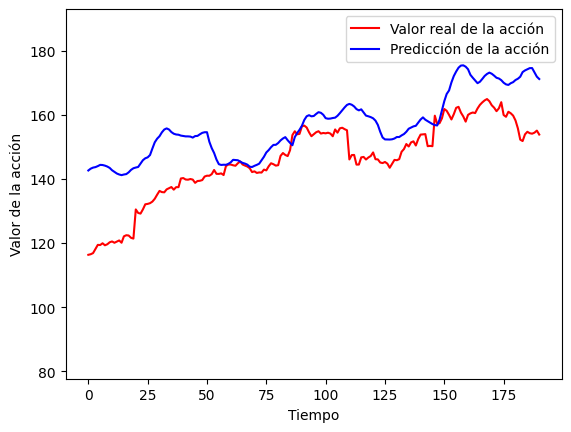

In [55]:
#
# Validación (predicción del valor de las acciones)
#
x_test = set_validacion.values
x_test = sc.transform(x_test)

X_test = []
for i in range(time_step,len(x_test)):
    X_test.append(x_test[i-time_step:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

prediccion = modelo.predict(X_test)
prediccion = sc.inverse_transform(prediccion)

# Graficar resultados
graficar_predicciones(set_validacion.values,prediccion)

In [56]:
prediccion=pd.DataFrame(prediccion, columns=['Predicciones'])
prediccion.head()

,Predicciones
0,142.644836
1,143.214233
2,143.544769
3,143.697937
4,144.010071


In [63]:
prediccion=np.array(prediccion['Predicciones'])

In [58]:
set_validacion_1=set_validacion.iloc[60:,:]

In [59]:
print(prediccion.shape)
print(set_validacion.shape)
print(set_validacion_1.shape)

(191, 1)
(251, 1)
(191, 1)


In [65]:
set_validacion_1['Predicciones']=prediccion

<ipython-input-65-c1c9461e2920>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_validacion_1['Predicciones']=prediccion


In [66]:
set_validacion_1

,High,Predicciones
Date,,
2017-03-30,144.50,142.644836
2017-03-31,144.27,143.214233
2017-04-03,144.12,143.544769
2017-04-04,144.89,143.697937
2017-04-05,145.46,144.010071
...,...,...
2017-12-22,175.42,174.585678
2017-12-26,171.47,174.603470
2017-12-27,170.78,173.264374


<Axes: xlabel='Date'>

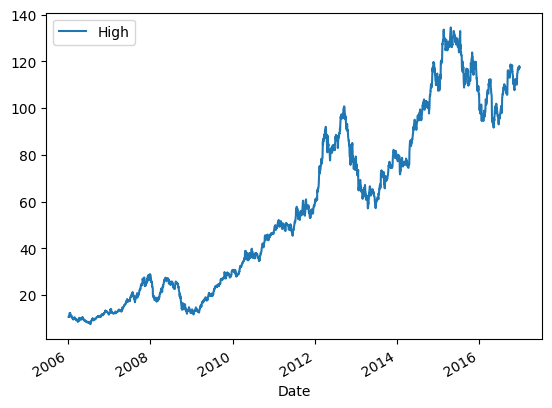

In [73]:
set_entrenamiento['High'].plot(legend=True)

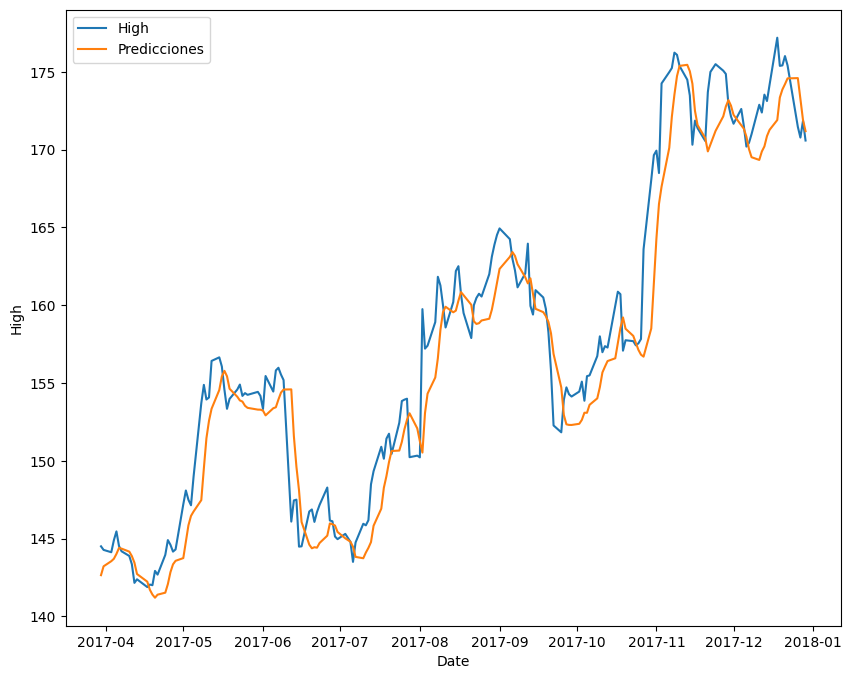

In [75]:
plt.figure(figsize=(10,8))
sns.lineplot(data=set_validacion_1, x=set_validacion_1.index, y='High',label='High')
sns.lineplot(data=set_validacion_1, x=set_validacion_1.index, y='Predicciones',label='Predicciones')
plt.show()